In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, Reshape
from keras.models import load_model, model_from_json

from sklearn.model_selection import train_test_split
import os
from os import mkdir, makedirs, remove, listdir
from collections import Counter


Using TensorFlow backend.


In [2]:
with open('./data/glove.6B.50d.txt','rb') as f:
    lines = f.readlines()
    
glove_weights = np.zeros((len(lines), 50))
words = []
for i, line in enumerate(lines):
    word_weights = line.split()
    words.append(word_weights[0])
    weight = word_weights[1:]
    glove_weights[i] = np.array([float(w) for w in weight])
word_vocab = [w.decode("utf-8") for w in words]

word2glove = dict(zip(word_vocab, glove_weights))

In [3]:
from keras.engine.topology import Layer
import keras.backend as K
from keras import initializers
import numpy as np

class Embedding2(Layer):

    def __init__(self, input_dim, output_dim, fixed_weights, embeddings_initializer='uniform', 
                 input_length=None, **kwargs):
        kwargs['dtype'] = 'int32'
        if 'input_shape' not in kwargs:
            if input_length:
                kwargs['input_shape'] = (input_length,)
            else:
                kwargs['input_shape'] = (None,)
        super(Embedding2, self).__init__(**kwargs)
    
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embeddings_initializer = embeddings_initializer
        self.fixed_weights = fixed_weights
        self.num_trainable = input_dim - len(fixed_weights)
        self.input_length = input_length
        
        w_mean = fixed_weights.mean(axis=0)
        w_std = fixed_weights.std(axis=0)
        self.variable_weights = w_mean + w_std*np.random.randn(self.num_trainable, output_dim)

    def build(self, input_shape, name='embeddings'):        
        fixed_weight = K.variable(self.fixed_weights, name=name+'_fixed')
        variable_weight = K.variable(self.variable_weights, name=name+'_var')
        
        self._trainable_weights.append(variable_weight)
        self._non_trainable_weights.append(fixed_weight)
        
        self.embeddings = K.concatenate([fixed_weight, variable_weight], axis=0)
        
        self.built = True

    def call(self, inputs):
        if K.dtype(inputs) != 'int32':
            inputs = K.cast(inputs, 'int32')
        out = K.gather(self.embeddings, inputs)
        return out

    def compute_output_shape(self, input_shape):
        if not self.input_length:
            input_length = input_shape[1]
        else:
            input_length = self.input_length
        return (input_shape[0], input_length, self.output_dim)


In [4]:
df = pd.read_csv('data/clean_actual_data_all_news.csv')
df.columns = ['title','text','label']
df.title = df.title.str.lower()
df.text = df.text.str.lower()

df.title = df.title.str.replace(r'http[\w:/\.]+','<URL>') # remove urls
df.text = df.text.str.replace(r'http[\w:/\.]+','<URL>') # remove urls
df.title = df.title.str.replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
df.text = df.text.str.replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
df.title = df.title.str.replace(r'\.\.+','.') #replace multple periods with a single one
df.text = df.text.str.replace(r'\.\.+','.') #replace multple periods with a single one
df.title = df.title.str.replace(r'\.',' . ') #replace periods with a single one
df.text = df.text.str.replace(r'\.',' . ') #replace multple periods with a single one
df.title = df.title.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df.text = df.text.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df.title = df.title.str.strip() 
df.text = df.text.str.strip() 
print(df.shape)
df.head()

(24319, 3)


,title,text,label
0,english businesses should be forced to show hy...,all premises in england that sell food should ...,REAL
1,tips should go to workers not employers says g...,tips in restaurants hotels and bars should go ...,REAL
2,sturgeon accused of breaking independence prom...,election debates are more common in holyrood p...,REAL
3,second scottish independence vote not yet on t...,nicola sturgeon has said a second independence...,REAL
4,bernie sanders vows a contested convention des...,bernie sanders acknowledged an uphill climb ah...,REAL


In [6]:
for li1 in range(len(df.text.values)):
    if not type(df.text.values[li1]) is str:
        print li1
        


all_text = ' '.join(df.text.values)
words = all_text.split()
u_words = Counter(words).most_common()
u_words_counter = u_words
u_words_frequent = [word[0] for word in u_words if word[1]>5] # we will only consider words that have been used more than 5 times

u_words_total = [k for k,v in u_words_counter]
word_vocab = dict(zip(word_vocab, range(len(word_vocab))))
word_in_glove = np.array([w in word_vocab for w in u_words_total])

words_in_glove = [w for w,is_true in zip(u_words_total,word_in_glove) if is_true]
words_not_in_glove = [w for w,is_true in zip(u_words_total,word_in_glove) if not is_true]

print('Fraction of unique words in glove vectors: ', sum(word_in_glove)/len(word_in_glove))

word2num = dict(zip(words_in_glove,range(len(words_in_glove))))
len_glove_words = len(word2num)
freq_words_not_glove = [w for w in words_not_in_glove if w in u_words_frequent]
b = dict(zip(freq_words_not_glove,range(len(word2num), len(word2num)+len (freq_words_not_glove))))
word2num.update(b)

word2num['<Other>'] = len(word2num)
num2word = dict(zip(word2num.values(), word2num.keys()))

int_text = [[word2num[word] if word in word2num else word2num['<Other>'] 
             for word in content.split()] for content in df.text.values]

print('The number of unique words are: ', len(u_words))
print('The first review looks like this: ')
print(int_text[0][:20])
print('And once this is converted back to words, it looks like: ')
print(' '.join([num2word[i] for i in int_text[0][:20]]))

('Fraction of unique words in glove vectors: ', 0)
('The number of unique words are: ', 188527)
The first review looks like this: 
[54, 7598, 6, 608, 7, 1562, 557, 100, 17, 803, 2, 3670, 9680, 3410, 2, 1638, 53, 1384, 5, 885]
And once this is converted back to words, it looks like: 
all premises in england that sell food should be forced to display hygiene ratings to drive up standards and protect


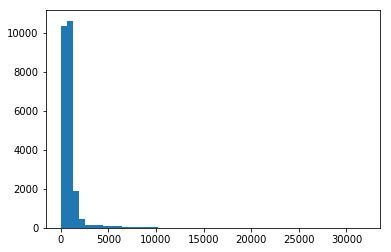

In [7]:
plt.hist([len(t) for t in int_text],50)
plt.show()

In [8]:
print('The number of articles greater than 500 in length is: ', np.sum(np.array([len(t)>500 for t in int_text])))
print('The number of articles less than 500 in length is: ', np.sum(np.array([len(t)<500 for t in int_text])))

('The number of articles greater than 500 in length is: ', 17520)
('The number of articles less than 500 in length is: ', 6776)


In [9]:
num2word[len(word2num)] = '<PAD>'
word2num['<PAD>'] = len(word2num)
for i, t in enumerate(int_text):
    if len(t)<500:
        int_text[i] = [word2num['<PAD>']]*(500-len(t)) + t
    elif len(t)>500:
        int_text[i] = t[:500]
    else:
        continue
x = np.array(int_text)
y = (df.label.values=='REAL').astype('int')  # converts all reals to 1 and all fakes to 0

# to get a 72,18,10 train-validate-test split, uncomment last line
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
#X_train,X_validate,y_train,y_validate = train_test_split(X_train,y_train,test_size = 0.2,random_state = 42)


In [10]:
df[df.label=='REAL'].text.values[0]

'all premises in england that sell food should be forced to display hygiene ratings to drive up standards and protect consumers from the risk of eating food prepared and cooked in unsanitary kitchens local councils said on monday . council environmental health teams score outlets from zero to five based on factors such as kitchen cleanliness cooking methods and food management but businesses in england do not have to display the socalled scores on the doors ratings they have been given . compulsory ratings already exist in wales and will be introduced in northern ireland in october . the local government association lga is calling for mandatory display to be extended to england to help raise food hygiene standards at restaurants pubs cafes takeaways sandwich shops supermarkets and delicatessens and to reassure consumers . the hygiene scores for more than 412000 english premises can currently be found on the food standards agencys website . businesses across england should by law be for

In [11]:
df[df.label=='FAKE'].text.values[0]

'18 share the amish in america have committed their vote to donald trump guaranteeing him the presidency . ap photo dennis system columbus oh ap history was made today in columbus ohio when more than 3 million amish poured into the city to see the american amish brotherhood aab an organization which acts as an informal governing body for the amish community endorse donald trump for president . that number represents a significant portion of the total amish population which the united states census bureau says numbers more than 20 million men and women nationwide all pledging their vote to trump for president . with the full force of the amish community behind him donald trump is now mathematically guaranteed to win the presidency in november . the organization typically meets once a year and the meetings usually consist of about 300 amish leaders who meet to discuss the challenges such as urban sprawl that face the community . this year however the organization wanted as many people in

In [14]:

model = Sequential()
model.add(Embedding2(len(word2num), 50,
                    fixed_weights=np.array([word2glove[w] for w in words_in_glove]))) # , batch_size=batch_size
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding2_1 (Embedding2)    (None, None, 50)          5486900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 5,516,405
Trainable params: 420,205
Non-trainable params: 5,096,200
_________________________________________________________________


In [16]:
'''
#batch_size = 128
batch_size = 64 # smaller for toy data
model.fit(X_train, y_train, batch_size=batch_size, epochs=15, validation_data=(X_test, y_test))
'''
model.load_weights("adam_first_trained_model.h5")

In [17]:
sentence = "North korea is testing out missiles on americans living overseas .".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(500-len(sentence_num)) + sentence_num
sentence_num = np.array(sentence_num)

model.predict(sentence_num[None,:])

array([[ 0.00297526]], dtype=float32)

In [18]:
' '.join([num2word[w] for w in sentence_num])

'<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

In [20]:
sentence = "President Trump is the greatest president of all time period .".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(0) + sentence_num
sentence_num = np.array(sentence_num)
model.predict(sentence_num[None,:])

array([[ 0.29150048]], dtype=float32)

In [24]:
loss,accuracy = model.evaluate(X_test, y_test)
print loss,accuracy

2432/2432 [==============================] - 6s 3ms/step
0.0717485454071 0.976973684211


In [26]:


true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0

count = 0
for li1 in range(len(X_test)):
    prediction = model.predict(X_test[li1][None,:])
    answer = y_test[li1]
    print prediction,answer,
    if (answer == 1 and prediction >= 0.5):
        print "correct"
        count += 1
        true_positive = true_positive + 1
        
    elif (answer == 0 and prediction < 0.5):
        print "correct"
        count += 1
        true_negative = true_negative + 1
    else:
        print "wrong"
        if answer == 0:
            false_positive = false_positive + 1
        else:
            false_negative = false_negative + 1

print count    
print true_positive,true_negative,false_positive,false_negative
print "Accuracy = ", float(count) / len(X_test)
print "Precision = ",float(true_positive) / (true_positive + false_positive)
print "Recall = ",float(true_positive) / (true_positive + false_negative)    

[[ 0.93789566]] 1 correct
[[ 0.9999243]] 1 correct
[[ 0.00632509]] 0 correct
[[ 0.99889803]] 1 correct
[[ 0.9998222]] 1 correct
[[ 0.19897299]] 0 correct
[[ 0.0033765]] 0 correct
[[ 0.99445701]] 1 correct
[[ 0.99978501]] 1 correct
[[ 0.99680185]] 1 correct
[[ 0.98966283]] 1 correct
[[ 0.99858934]] 1 correct
[[ 0.99987125]] 1 correct
[[ 0.99951601]] 1 correct
[[ 0.99890733]] 1 correct
[[ 0.00346469]] 0 correct
[[ 0.99955124]] 1 correct
[[ 0.00356717]] 0 correct
[[ 0.99985445]] 1 correct
[[ 0.99971622]] 1 correct
[[ 0.04429479]] 0 correct
[[ 0.98781186]] 1 correct
[[ 0.99978822]] 1 correct
[[ 0.99979585]] 1 correct
[[ 0.9991672]] 1 correct
[[ 0.00134279]] 0 correct
[[ 0.99861717]] 1 correct
[[ 0.92907745]] 1 correct
[[ 0.99977547]] 1 correct
[[ 0.99953318]] 1 correct
[[ 0.99981946]] 1 correct
[[ 0.99987924]] 1 correct
[[ 0.95498031]] 1 correct
[[ 0.00193715]] 0 correct
[[ 0.66624457]] 1 correct
[[ 0.07952852]] 0 correct
[[ 0.99963915]] 1 correct
[[ 0.95345527]] 1 correct
[[ 0.99947613]] 

[[ 0.99984276]] 1 correct
[[ 0.99973816]] 1 correct
[[ 0.99595475]] 1 correct
[[ 0.01600942]] 0 correct
[[ 0.99412882]] 1 correct
[[ 0.9962095]] 1 correct
[[ 0.99982893]] 1 correct
[[ 0.99673271]] 1 correct
[[ 0.99988246]] 1 correct
[[ 0.99993432]] 1 correct
[[ 0.00226035]] 0 correct
[[ 0.99977356]] 1 correct
[[ 0.99985719]] 1 correct
[[ 0.99443322]] 1 correct
[[ 0.99974805]] 1 correct
[[ 0.98758274]] 0 wrong
[[ 0.99979776]] 1 correct
[[ 0.00104422]] 0 correct
[[ 0.99867034]] 1 correct
[[ 0.99979049]] 1 correct
[[ 0.99974149]] 1 correct
[[ 0.99953592]] 1 correct
[[ 0.00429175]] 0 correct
[[ 0.00275508]] 0 correct
[[ 0.99718875]] 1 correct
[[ 0.98855597]] 1 correct
[[ 0.99990869]] 1 correct
[[ 0.99906319]] 1 correct
[[ 0.99919337]] 1 correct
[[ 0.9998939]] 1 correct
[[ 0.99991345]] 1 correct
[[ 0.99991]] 1 correct
[[ 0.99984467]] 1 correct
[[ 0.99970526]] 1 correct
[[ 0.9996587]] 1 correct
[[ 0.00633683]] 0 correct
[[ 0.26664326]] 0 correct
[[  5.44537288e-05]] 0 correct
[[ 0.99762565]]

[[ 0.97818106]] 1 correct
[[ 0.99886215]] 1 correct
[[ 0.99972504]] 1 correct
[[ 0.99987006]] 1 correct
[[ 0.99940515]] 1 correct
[[ 0.99944943]] 1 correct
[[ 0.99961323]] 1 correct
[[ 0.99963391]] 1 correct
[[ 0.99998796]] 1 correct
[[ 0.00094278]] 0 correct
[[ 0.99962628]] 1 correct
[[ 0.9998073]] 1 correct
[[ 0.99993515]] 1 correct
[[ 0.00156333]] 0 correct
[[ 0.99994075]] 1 correct
[[ 0.99988437]] 1 correct
[[ 0.99807334]] 1 correct
[[ 0.00206774]] 0 correct
[[ 0.99972135]] 1 correct
[[ 0.00970138]] 0 correct
[[ 0.00290002]] 0 correct
[[ 0.99925727]] 1 correct
[[ 0.02347327]] 0 correct
[[ 0.99298096]] 1 correct
[[ 0.99988306]] 1 correct
[[ 0.99941087]] 1 correct
[[ 0.99616975]] 0 wrong
[[ 0.00049225]] 0 correct
[[ 0.9888708]] 1 correct
[[ 0.99990451]] 1 correct
[[ 0.99404597]] 1 correct
[[ 0.00163718]] 0 correct
[[ 0.50049251]] 0 wrong
[[ 0.13464488]] 1 wrong
[[ 0.99940312]] 1 correct
[[ 0.99639279]] 1 correct
[[ 0.84556556]] 0 wrong
[[ 0.00371473]] 0 correct
[[ 0.00107758]] 0 corr

[[ 0.99943608]] 1 correct
[[ 0.00101546]] 0 correct
[[ 0.99947244]] 1 correct
[[ 0.0775151]] 0 correct
[[ 0.0003171]] 0 correct
[[ 0.99971765]] 1 correct
[[ 0.20756125]] 0 correct
[[ 0.00047399]] 0 correct
[[ 0.00041174]] 0 correct
[[ 0.99961507]] 1 correct
[[ 0.99914622]] 1 correct
[[ 0.99964535]] 1 correct
[[ 0.99967134]] 1 correct
[[ 0.99939382]] 1 correct
[[ 0.99980897]] 1 correct
[[ 0.99893957]] 1 correct
[[ 0.9998908]] 1 correct
[[ 0.9998554]] 1 correct
[[ 0.99991512]] 1 correct
[[ 0.99987137]] 1 correct
[[ 0.99964905]] 1 correct
[[ 0.99940026]] 1 correct
[[ 0.99981934]] 1 correct
[[ 0.03422564]] 0 correct
[[ 0.9995783]] 1 correct
[[ 0.99933016]] 1 correct
[[ 0.99885499]] 1 correct
[[ 0.99946755]] 1 correct
[[ 0.99990165]] 1 correct
[[ 0.9997353]] 1 correct
[[ 0.99988067]] 1 correct
[[ 0.00281169]] 0 correct
[[ 0.99977463]] 1 correct
[[ 0.39073163]] 1 wrong
[[ 0.99991083]] 1 correct
[[ 0.99978858]] 1 correct
[[ 0.99923289]] 1 correct
[[ 0.99829036]] 1 correct
[[ 0.99970669]] 1 co

[[ 0.99962461]] 1 correct
[[ 0.99955088]] 1 correct
[[ 0.99983931]] 1 correct
[[ 0.99983263]] 1 correct
[[ 0.99966204]] 1 correct
[[ 0.00325379]] 0 correct
[[ 0.99931002]] 1 correct
[[ 0.99955004]] 1 correct
[[ 0.999255]] 1 correct
[[ 0.99974889]] 1 correct
[[ 0.99989009]] 1 correct
[[ 0.99914753]] 1 correct
[[ 0.02661421]] 0 correct
[[ 0.00451173]] 0 correct
[[ 0.42669341]] 1 wrong
[[ 0.99972552]] 1 correct
[[ 0.11482222]] 1 wrong
[[ 0.03705286]] 1 wrong
[[ 0.99954563]] 1 correct
[[ 0.99817204]] 1 correct
[[ 0.99919337]] 1 correct
[[ 0.99976307]] 1 correct
[[ 0.99972516]] 1 correct
[[ 0.98968852]] 1 correct
[[ 0.01118265]] 0 correct
[[ 0.00686315]] 0 correct
[[ 0.99954128]] 1 correct
[[ 0.99588364]] 1 correct
[[ 0.00352824]] 0 correct
[[ 0.99997675]] 1 correct
[[ 0.00322914]] 0 correct
[[ 0.99989784]] 1 correct
[[ 0.99964476]] 1 correct
[[ 0.99871695]] 1 correct
[[ 0.99959499]] 1 correct
[[ 0.98144597]] 1 correct
[[ 0.99976152]] 1 correct
[[ 0.99945766]] 1 correct
[[ 0.99976534]] 1 co

[[ 0.00098276]] 0 correct
[[ 0.99992967]] 1 correct
[[ 0.99392998]] 1 correct
[[ 0.99941778]] 1 correct
[[ 0.93864077]] 1 correct
[[ 0.99758112]] 1 correct
[[ 0.98304409]] 0 wrong
[[ 0.99980456]] 1 correct
[[ 0.96740639]] 1 correct
[[ 0.99988413]] 1 correct
[[ 0.9992193]] 1 correct
[[ 0.99124897]] 1 correct
[[ 0.99885368]] 1 correct
[[ 0.99971563]] 1 correct
[[ 0.99976677]] 1 correct
[[ 0.9996357]] 1 correct
[[ 0.99988389]] 1 correct
[[ 0.99142551]] 1 correct
[[ 0.00315119]] 0 correct
[[ 0.99979264]] 1 correct
[[ 0.99943882]] 1 correct
[[ 0.98686522]] 1 correct
[[ 0.00314019]] 0 correct
[[ 0.99981505]] 1 correct
[[ 0.01277544]] 0 correct
[[ 0.99984682]] 1 correct
[[ 0.99951041]] 1 correct
[[ 0.99358314]] 1 correct
[[ 0.99992847]] 1 correct
[[ 0.99974543]] 1 correct
[[ 0.99677724]] 1 correct
[[ 0.99981469]] 1 correct
[[ 0.99856758]] 1 correct
[[ 0.99691415]] 1 correct
[[ 0.99982697]] 1 correct
[[ 0.00089407]] 0 correct
[[ 0.99958104]] 1 correct
[[ 0.99972337]] 1 correct
[[ 0.99933225]] 

[[ 0.0012322]] 0 correct
[[ 0.99676621]] 1 correct
[[ 0.99850571]] 1 correct
[[ 0.99964392]] 1 correct
[[ 0.99988246]] 1 correct
[[ 0.00172677]] 0 correct
[[ 0.99978572]] 1 correct
[[ 0.00263577]] 0 correct
[[ 0.93789566]] 1 correct
[[ 0.9996438]] 1 correct
[[ 0.99981433]] 1 correct
[[ 0.000664]] 0 correct
[[ 0.99969113]] 1 correct
[[ 0.98848522]] 1 correct
[[ 0.99998629]] 1 correct
[[ 0.99973279]] 1 correct
[[ 0.00065272]] 0 correct
[[ 0.98526603]] 1 correct
[[ 0.99984944]] 1 correct
[[ 0.99949503]] 1 correct
[[ 0.01370912]] 0 correct
[[ 0.9984687]] 1 correct
[[ 0.99948251]] 1 correct
[[ 0.99951172]] 1 correct
[[ 0.99981087]] 1 correct
[[ 0.99974602]] 1 correct
[[ 0.99983203]] 1 correct
[[ 0.0145507]] 1 wrong
[[ 0.99868232]] 1 correct
[[ 0.99973136]] 1 correct
[[ 0.00326235]] 0 correct
[[ 0.00049327]] 0 correct
[[ 0.99979287]] 1 correct
[[ 0.99971408]] 1 correct
[[ 0.53539163]] 1 correct
[[ 0.99973243]] 1 correct
[[ 0.02799999]] 1 wrong
[[ 0.99955374]] 1 correct
[[ 0.99920434]] 1 corr

[[ 0.99871659]] 1 correct
[[ 0.9997918]] 1 correct
[[ 0.99821007]] 1 correct
[[ 0.99986529]] 1 correct
[[ 0.00391423]] 0 correct
[[ 0.99963856]] 0 wrong
[[ 0.98256981]] 1 correct
[[ 0.00028154]] 0 correct
[[ 0.99991155]] 1 correct
[[ 0.99985361]] 1 correct
[[ 0.99978703]] 1 correct
[[ 0.99970752]] 1 correct
[[ 0.00278916]] 0 correct
[[ 0.99525237]] 1 correct
[[ 0.97494364]] 1 correct
[[ 0.99949801]] 1 correct
[[ 0.99907541]] 1 correct
[[ 0.99927229]] 1 correct
[[ 0.9817965]] 1 correct
[[ 0.00367415]] 0 correct
[[ 0.99722099]] 1 correct
[[ 0.99966204]] 1 correct
[[ 0.99986267]] 1 correct
[[ 0.90402842]] 1 correct
[[ 0.99705899]] 1 correct
[[ 0.999816]] 1 correct
[[ 0.99944979]] 1 correct
[[ 0.99992537]] 1 correct
[[ 0.99994171]] 1 correct
[[ 0.99865037]] 1 correct
[[ 0.99973518]] 1 correct
[[ 0.99984205]] 1 correct
[[ 0.00134748]] 0 correct
[[ 0.99953771]] 1 correct
[[ 0.99983037]] 1 correct
[[ 0.99975508]] 1 correct
[[ 0.01100042]] 0 correct
[[ 0.99984169]] 1 correct
[[ 0.99916434]] 1 